In [1]:
import pandas as pd
from glob import glob
from lifelines.utils import concordance_index as lfcindex
import matplotlib.pyplot as plt
import seaborn as sns
from samecode.survival.plot import KMPlot
from shap.plots import colors
#colors = [colors.blue_rgb, colors.red_rgb]
colors = ['darkblue', 'red']

/home/shenwanxiang/anaconda3/envs/compass/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('./results/All_method_raw_test.csv', index_col=0)
df.index.name = 'Index'
df.learning_type.value_counts()

TransferLearningSurvival    7740
BaselineSurvival            7740
checkpoint prediction       5160
TMB                         2580
Name: learning_type, dtype: int64

In [3]:
y = df[df.model_name == 'TMB']
tmb_patients = y[~y.score.isna()]
df = df[df.index.isin(tmb_patients.index)]

In [4]:
ct_baseline = df[df.learning_type == 'BaselineSurvival']
ct_transfer = df[df.learning_type == 'TransferLearningSurvival']

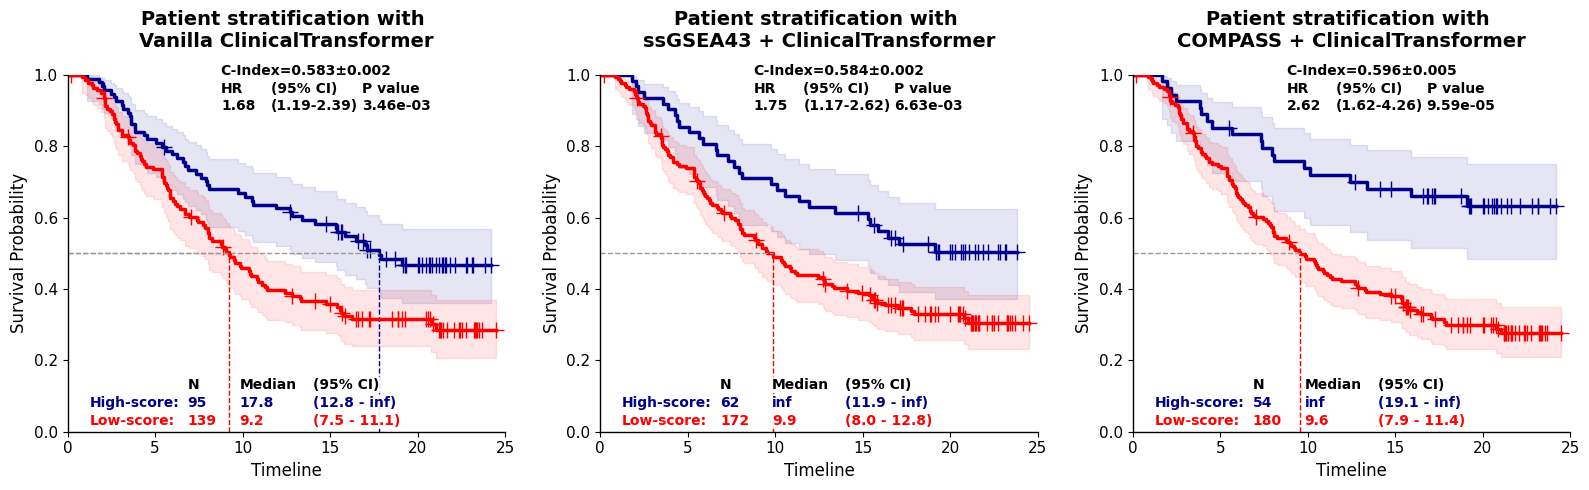

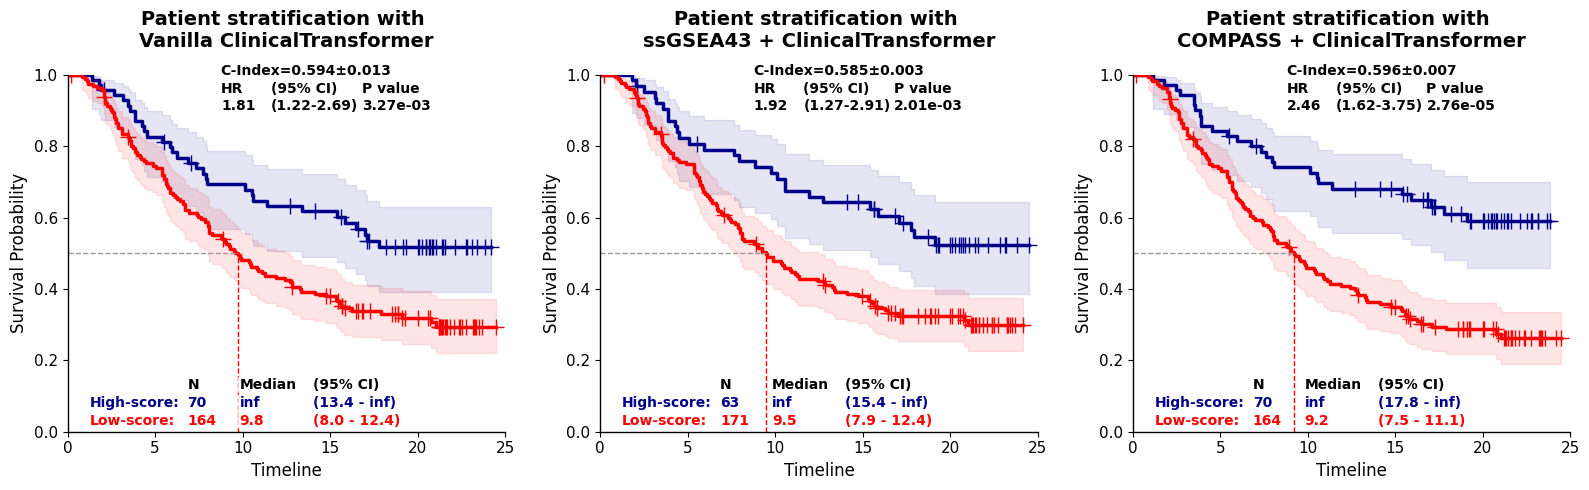

In [9]:
cohort = 'IMVigor210'
xmax = 25
model_names = ['Vanilla ClinicalTransformer', 
               'ssGSEA43 + ClinicalTransformer', 
               'COMPASS + ClinicalTransformer']

dfus = [ct_baseline, ct_transfer]
comparisons = [['Low-score', 'High-score', '']]

for dfu in dfus:    
    dfc1 = dfu[dfu.cohort == cohort]
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(16, 5))

    for ax, model_name in zip(axes, model_names):

        dfp1 = dfc1[dfc1.model_name == model_name]
        desc = dfp1.learning_type.unique()[0]
        title = f'Patient stratification with \n{model_name}'

        group = dfp1.reset_index().groupby(['Index'])['group'].apply(lambda x:x.mode()[0]).to_frame()
        time = dfp1.reset_index().groupby(['Index'])['time'].apply(lambda x:x.mode()[0]).to_frame()
        event = dfp1.reset_index().groupby(['Index'])['event'].apply(lambda x:x.mode()[0]).to_frame()
        score = dfp1.reset_index().groupby(['Index'])['score'].apply(lambda x:x.mean()).to_frame()
        dfp2 = group.join(time).join(event).join(score)

        KMPlot(dfp2, time='time', event='event', label=["group"]).plot(
            ax=ax,
            colors=colors, #['r', 'b'],
            comparisons=comparisons,
            title = title,
            labels=['High-score','Low-score', ],
            ci_show=True,
            #ci_alpha=0.10,       
            hr_color = 'black',
            x_legend = 0.05, y_legend = 0.12, legend_font_size=10, 
            x_hr_legend = 0.3, y_hr_legend = 0.95, hr_font_size=10,
            linewidth=2.5
        );

        for poly in ax.collections:
            poly.set_alpha(0.1)  # 修改置信区间阴影透明度

        cindex = dfp1.groupby('score_seed').apply(lambda x:lfcindex(x['time'], 
                                                                    x['score'], 
                                                                    x['event']))
        
        cindex_format = "C-Index={:.3f}±{:.3f}".format(cindex.mean(),cindex.std() )
        
    #     for t in ax.texts:  
    #         t.set_fontweight('normal')
        ax.set_ylim(0,1)
        ax.set_xlim(0,xmax)
        ax.xaxis.label.set_fontweight('normal')
        ax.yaxis.label.set_fontweight('normal')

        ax.text(0.35, 1, cindex_format, 
                transform=ax.transAxes,   weight='bold', fontsize=10, color='black');

        ax.set_title(title, fontsize=14,  pad=20)  # pad=20 weight='bold',
        ax.title.set_fontweight('bold')

    sns.despine(offset=0)
    fig.tight_layout(w_pad=2)

    fig.savefig(f'./results/KM_{cohort}_{desc}_clinical_transformer.svg', bbox_inches = 'tight')

In [6]:
comps = df[df.model_name == 'COMPASS PFT model']
tmb = df[df.model_name == 'TMB']
csp = df[df.model_name == 'CSP survival model']

In [7]:
comps.group.value_counts()

Non-responder    1265
Responder         619
Name: group, dtype: int64

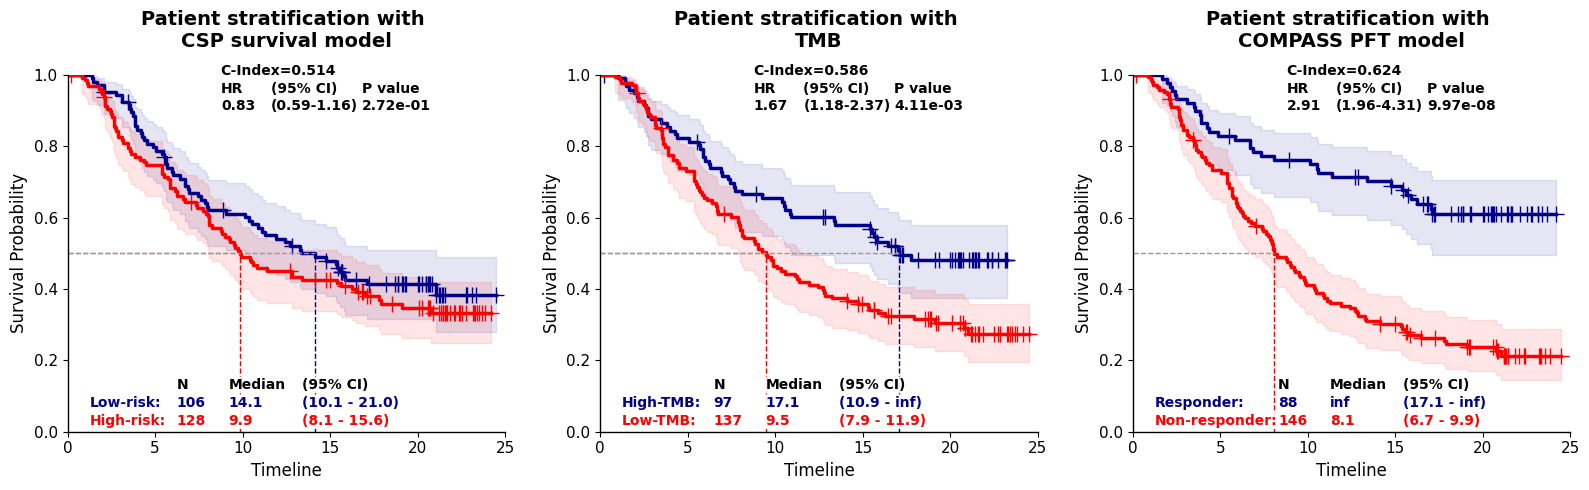

In [10]:

dfus = [csp, tmb, comps]

cps =( [['Low-risk', 'High-risk', '']],  [['Low-TMB', 'High-TMB', '']],  [['Non-responder','Responder',  '']])
lbs = [['Low-risk', 'High-risk'],  ['High-TMB','Low-TMB'],  ['Responder','Non-responder']]

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(16, 5))

for ax, dfu, comparisons, labels in zip(axes, dfus, cps,lbs):
 
    dfc1 = dfu[dfu.cohort == cohort]
    model_name = dfc1.model_name.unique()[0]
    
    dfp1 = dfc1[dfc1.model_name == model_name]
    desc = dfp1.learning_type.unique()[0]
    title = f'Patient stratification with \n{model_name}'

    if model_name =='COMPASS PFT model':
        c = [colors[0], colors[1]]
    else:
        c = [colors[0], colors[1]]
        
    #

    if model_name =='COMPASS PFT model':    
        time = dfp1.reset_index().groupby(['Index'])['time'].apply(lambda x:x.mode()[0]).to_frame()
        event = dfp1.reset_index().groupby(['Index'])['event'].apply(lambda x:x.mode()[0]).to_frame()
        score = dfp1.reset_index().groupby(['Index'])['score'].apply(lambda x:x.mean()).to_frame()
        group = score.score.apply(lambda x: 'Responder' if x>=0.5 else 'Non-responder').to_frame(name = 'group')
        dfp2 = group.join(time).join(event).join(score)
    else:
        dfp2 = dfp1[dfp1.score_seed == 42]
    KMPlot(dfp2, time='time', event='event', label=["group"]).plot(
        ax=ax,
        colors=c, #['r', 'b'],
        comparisons=comparisons,
        labels = labels,
        title = title,
        ci_show=True,     
        hr_color = 'black',
        x_legend = 0.05, y_legend = 0.12, legend_font_size=10, 
        x_hr_legend = 0.3, y_hr_legend = 0.95, hr_font_size=10,
        linewidth=2.5
    );

    for poly in ax.collections:
        poly.set_alpha(0.1)  # 修改置信区间阴影透明度

    if model_name == 'CSP survival model':
        cindex = dfp1.groupby('score_seed').apply(lambda x:lfcindex(x['time'], 
                                                                    -x['score'],
                                                                    x['event']))
    else:
        cindex = dfp1.groupby('score_seed').apply(lambda x:lfcindex(x['time'], 
                                                                    x['score'],
                                                                    x['event']))

    cindex_format = "C-Index={:.3f}".format(cindex.mean())

#     for t in ax.texts:  
#         t.set_fontweight('normal')
    ax.set_ylim(0,1)
    ax.set_xlim(0,xmax)
    ax.xaxis.label.set_fontweight('normal')
    ax.yaxis.label.set_fontweight('normal')

    ax.text(0.35, 1, cindex_format, 
            transform=ax.transAxes,   weight='bold', fontsize=10, color='black');

    ax.set_title(title, fontsize=14,  pad=20)  # pad=20 weight='bold',
    ax.title.set_fontweight('bold')

sns.despine(offset=0)
fig.tight_layout(w_pad=2)

fig.savefig(f'./results/KM_{cohort}_CSP_TMB_COMPASS.svg', bbox_inches = 'tight')